## ***Grafo***

### Import

In [18]:
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

### Definizione della Rete, Seller e Buyer

##### Grafo

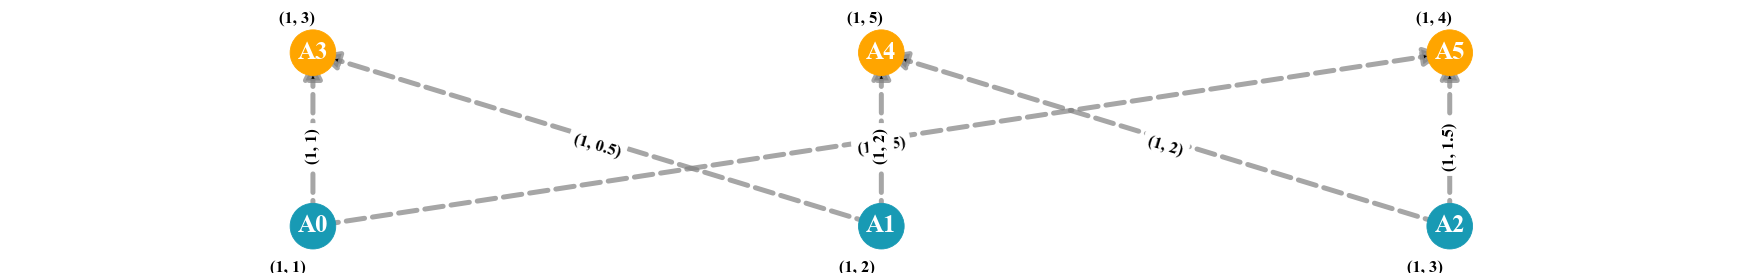

In [19]:
G = nx.DiGraph(); G.graph['Name'] = 'Grafico'; draw = True;  # Variabile per disegnare il grafo

with open('./JSON/Vertex/P3S-V.json') as file:
    json_vertex = file.read()

with open('./JSON/Edges/P3S-E.json') as file:
    json_edges = file.read()

nodes, edges = [], []; sb = []; seller_groups = 0; # [Num_Seller,Num_Buyer], # Num_Seller_Group
vrt = json.loads(json_vertex); edg = json.loads(json_edges)

for i,item in enumerate(vrt):
    if(i == 0):
        sb = vrt[0]['sb']
        seller_groups = vrt[0]['seller_groups']
    else:
        node_name = item["Node_Name"]
        node_attributes = {
            "Prezzo_Unita": item["Prezzo_Unita"],
            "Disponibilita": item["Disponibilita"],
            "group": item["group"]
        }
        nodes.append((node_name, node_attributes))

for item in edg:
    start_node = item["Start_Node_Name"]
    end_node = item["End_Node_Name"]
    edge_attributes = {
        "capacity": item["capacity"],
        "price": item["price"]
    }
    edges.append((start_node, end_node, edge_attributes))

G.add_nodes_from(nodes); G.add_edges_from(edges); 


if(draw):
    fig = plt.figure(figsize=(30,5), dpi=60); ax = plt.gca(); ax.margins(0.20); plt.tight_layout(); pos = {};
    pos = {node: (2/sb[0]*(i+1),0.75) if i < sb[0] else (2/sb[1]*(i%sb[0]+1),1) for i, node in enumerate(G.nodes)} # Funziona se i buyer sono meno dei seller
    pos_node_label = {p:(pos[p][0]-0.05, pos[p][1]-0.05) if i < sb[0] else (pos[p][0]-0.04,pos[p][1]+0.06) for i,p in enumerate(pos)}
    color = ["#189AB4" for _ in range(sb[0])] + ['orange' for _ in range(sb[1])]; pos_edge_label = {p:(pos[p][0],pos[p][1]-0.01) for p in pos}; 
    
    node_labels={n:(d["Disponibilita"],d["Prezzo_Unita"]) for n,d in G.nodes(data=True)}; edge_labels = {(u,v): (d["capacity"],d["price"]) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G,pos=pos,width=6,arrowsize=45,alpha=0.7,edge_color="gray",style="dashed") # Draw edges
    nx.draw_networkx_edge_labels(G,pos=pos_edge_label,edge_labels=edge_labels,label_pos=0.5,font_size=20,font_family="Times New Roman", font_weight="bold"); # Draw Edges Labels
    nx.draw_networkx_labels(G,pos=pos_node_label,labels=node_labels,font_color="black",font_size=20,font_family="Times New Roman", font_weight="bold",horizontalalignment='left',verticalalignment='top') # Draw Node Labels
    nx.draw(G,pos=pos,with_labels=True,node_size=3000,node_color=color,font_color="white",font_size=30,font_family="Times New Roman", font_weight="bold",width=0) 

### Aggiunta Archi Indiretti

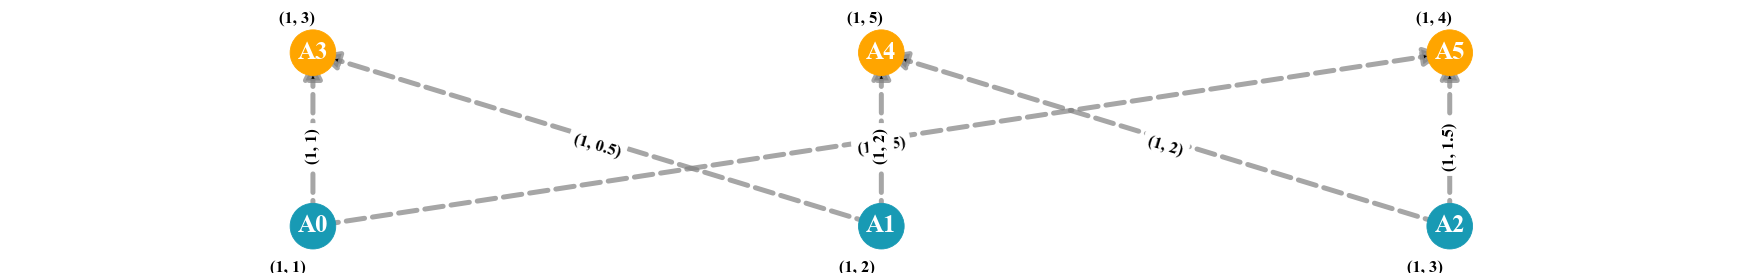

In [20]:
red_edges = [];
for node_start in G.nodes:
    for node_stop in G.nodes:
        if(str(node_start) == str(node_stop).replace("'",'') and "'" in str(node_stop)):
            G.add_edges_from([(str(node_stop),str(node_start),{'capacity':'inf','price':0})])
            red_edges.append((str(node_stop),str(node_start))); #print(node_start,node_stop)

if(draw):
    fig = plt.figure(figsize=(30,5), dpi=60); ax = plt.gca(); ax.margins(0.20); plt.tight_layout();
    edge_labels = {(u,v): (d["capacity"],d["price"]) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G,pos=pos,width=6,arrowsize=45,alpha=0.7,edge_color="gray",style="dashed") # Draw edges
    nx.draw_networkx_edges(G,pos=pos,width=6,edgelist=red_edges,arrowsize=45,alpha=0.7,edge_color="red",style="dashed") # Draw edges
    nx.draw_networkx_edge_labels(G,pos=pos_edge_label,edge_labels=edge_labels,label_pos=0.5,font_size=20,font_family="Times New Roman", font_weight="bold"); # Draw Edges Labels
    nx.draw_networkx_labels(G,pos=pos_node_label,labels=node_labels,font_color="black",font_size=20,font_family="Times New Roman", font_weight="bold",horizontalalignment='left',verticalalignment='top') # Draw Node Labels
    nx.draw(G,pos=pos,with_labels=True,node_color=color,node_size=3000,font_color="white",font_size=30,font_family="Times New Roman", font_weight="bold",width=0)

## ***Quantum Genetic Algorithm (HQGA)***

#### Import

In [21]:
import sys
import math
import random
import numpy as np
from tqdm import tqdm
from qiskit import Aer
import matplotlib.pyplot as plt
sys.path.insert(1, './Codice/HQGA/') # caution: path[0] is reserved for script path (or '' in REPL)
import utils
import hqga_utils
import hqga_algorithm
import Problems as p

#random.seed(42) # Set the random seed to a fixed value

#### Extraction of the Information from the Graph

In [22]:
costi, done = [], []; var_cap_tran = np.zeros((0,G.number_of_edges()),dtype=int); cap_tran = np.zeros(0,dtype=int); 

var_cap_seller = np.zeros((sb[0],G.number_of_edges()),dtype=int); cap_seller = np.zeros((sb[0]),dtype=int);
var_cap_buyer = np.zeros((sb[1],G.number_of_edges()),dtype=int); cap_buyer = np.zeros((sb[1]),dtype=int);

# Calcolo dei Costi
for edge in G.edges(data=True): 
    if("'" not in str(edge[0])):
        costi.append(round(edge[2]['price'] + G.nodes[edge[0]]['Prezzo_Unita'],2))
    else: costi.append(0)

# Vincoli Disponibilità Seller
for i in range(sb[0]):
    vars = []
    for out_edge in G.out_edges(list(G.nodes())[i]): vars.append(list(G.edges).index(out_edge)); var_cap_seller[i][list(G.edges).index(out_edge)] = 1
    for in_edge in G.in_edges(list(G.nodes())[i]): vars.append(-list(G.edges).index(in_edge)); var_cap_seller[i][list(G.edges).index(out_edge)] = -1
    cap_seller[i] = G.nodes[list(G.nodes())[i]]['Disponibilita']

# Vincoli Richieste Buyer
for j in range(sb[1]):
    vars = []
    for out_edge in G.out_edges(list(G.nodes())[sb[0]+j]): vars.append(list(G.edges).index(out_edge)); var_cap_buyer[j][list(G.edges).index(out_edge)] = 1
    for in_edge in G.in_edges(list(G.nodes())[sb[0]+j]): vars.append(-list(G.edges).index(in_edge) if list(G.edges).index(in_edge) != 0 else '-0'); var_cap_buyer[j][list(G.edges).index(in_edge)] = -1
    cap_buyer[j] = -G.nodes[list(G.nodes())[sb[0]+j]]['Disponibilita']

# Vincoli Capacità Archi
for edge1 in G.edges(data=True):
    bin = np.zeros(G.number_of_edges(),dtype=int);
    if("'" not in str(edge1[0])):
        vars = [];
        for edge2 in G.edges(): 
            if(edge1 != edge2 and edge1[1] == edge2[1] and G.nodes[edge1[0]]['group'] == G.nodes[edge2[0]]['group'] and list(G.edges).index(edge2) not in done):
                vars.append(list(G.edges).index(edge2)); done.append(list(G.edges).index(edge2)); bin[list(G.edges).index(edge2)] = 1
        if(vars != []): 
            var_cap_tran = np.append(var_cap_tran,[bin],axis=0); cap_tran = np.append(cap_tran,[edge1[2]['capacity']])


def check_constraint(point): return (np.dot(var_cap_seller,point) <= cap_seller).all() and \
                                    (np.dot(var_cap_buyer,point) == cap_buyer).all() and \
                                    (np.dot(var_cap_tran,point) <= cap_tran).all()

#print(costi); print(var_cap_seller,cap_seller); print(var_cap_buyer,cap_buyer); print(var_cap_tran,cap_tran);
#point = np.array([1,0,2,0,0,2]); check_constraint(point); 
#point = np.array([2,2]); check_constraint(point)

#### Definition of the Element

In [23]:
def test(qga_algorithm,simulator,num_runs,init_points,correct,problem): #,path    
    chr=[]; fit=[]; eval=[]; upper_bound = problem.upper_bounds[0]
    # build circuit
    for k,init in enumerate(init_points):
        #params=hqga_utils.ReinforcementParameters(3,5,math.pi/16,math.pi/16,0.3) #Popolazione, Generazioni,Rotazione,Mutazione 
        params=hqga_utils.Parameters(3,133,init,0.3,elitism=hqga_utils.ELITISM_Q) #Deterministic Version
        params.draw_circuit = False; params.verbose = False; num_eval=(params.max_gen+1)*params.pop_size; device_features = utils.device(simulator,False)
        circuit = hqga_utils.setupCircuit(params.pop_size,problem.dim*problem.num_bit_code)
        for i in range(num_runs):
            hqga_utils.resetCircuit(circuit)
            gBest = qga_algorithm(device_features,circuit,params,problem)
            
            r_new = [int(gBest.chr[i*np.binary_repr(upper_bound).__len__():(i+1)*np.binary_repr(upper_bound).__len__()],2) for i in range(G.number_of_edges())]
            if(check_constraint(r_new)): # Se i vincoli sono soddisfatti allora stampa i risultati
                print('\nMinima Spesa:',np.dot(costi,r_new),'€\t\tinit:',init,'\tbest fit:',params.pop_size*(gBest.gen+1))
                for i,edge in enumerate(G.edges()):
                    print(f'(Venditore: {edge[0]}, Compratore: {edge[1]}) =','Quantità:',r_new[i])
                #if(r_new == [2,2]): correct[k] += 1 # Problema P1
                #if(r_new == [0,0,1,1]): correct[k] += 1 # Problema P2S
                if(r_new == [0,1,1,0,1,0]): correct[k] += 1 # Problema P3S
            else: 
                print('\nMinima Spesa NON Ottimale:',np.dot(costi,r_new),'€\t\tinit:',init,'\tbest fit:',gBest.gen)
                for i,edge in enumerate(G.edges()):
                    print(f'(Venditore: {edge[0]}, Compratore: {edge[1]}) =','Quantità:',r_new[i])

    #    gBest, chromosome_evolution,bests=qga_algorithm(dev_features, circuit, params,problem)
    #     chr.append(str(problem.convert(gBest.chr)))
    #     fit.append(gBest.fitness)
    #     eval.append(gBest.gen)
    #     utils.writeBestsXls(path+"Bests_"+str(i)+".xlsx", bests)
    #     utils.writeChromosomeEvolutionXls(path+"ChromosomeEvolution_"+str(i)+".xlsx", chromosome_evolution)
    # utils.writeFinalXls(path+"Final.xlsx", chr, fit, eval)


#### PARAMETERS ############################
#num_runs=10; init_points = [math.pi/32]; correct = [0,0,0]
num_runs=10; init_points = [math.pi/8,math.pi/16,math.pi/32]; correct = [0,0,0]
simulator = Aer.get_backend('qasm_simulator'); #directory_name="results/"
dim = G.number_of_edges(); lower=[0]*dim; upper=[1]*dim; bit_code = np.binary_repr(upper[0]).__len__()
problems=[p.FlowProblem(constr=check_constraint,dim=dim,lower_bounds=lower,upper_bounds=upper,num_bit_code=bit_code,costs=costi)]; 
algorithm= hqga_algorithm.runQGA

for problem in problems:
    #namefile=directory_name+str(params)+"_"+str(num_eval)+"/"+problem.name+"/"
    #if not os.path.exists(namefile): os.makedirs(namefile)
    #test(algorithm,device_features, namefile,num_runs, params, problem)
    test(algorithm,simulator,num_runs,init_points,correct,problem)


Minima Spesa: 10.0 €		init: 0.39269908169872414 	best fit: 201
(Venditore: A0, Compratore: A3) = Quantità: 0
(Venditore: A0, Compratore: A5) = Quantità: 1
(Venditore: A1, Compratore: A3) = Quantità: 1
(Venditore: A1, Compratore: A4) = Quantità: 0
(Venditore: A2, Compratore: A4) = Quantità: 1
(Venditore: A2, Compratore: A5) = Quantità: 0

Minima Spesa: 10.0 €		init: 0.39269908169872414 	best fit: 102
(Venditore: A0, Compratore: A3) = Quantità: 0
(Venditore: A0, Compratore: A5) = Quantità: 1
(Venditore: A1, Compratore: A3) = Quantità: 1
(Venditore: A1, Compratore: A4) = Quantità: 0
(Venditore: A2, Compratore: A4) = Quantità: 1
(Venditore: A2, Compratore: A5) = Quantità: 0

Minima Spesa: 10.0 €		init: 0.39269908169872414 	best fit: 345
(Venditore: A0, Compratore: A3) = Quantità: 0
(Venditore: A0, Compratore: A5) = Quantità: 1
(Venditore: A1, Compratore: A3) = Quantità: 1
(Venditore: A1, Compratore: A4) = Quantità: 0
(Venditore: A2, Compratore: A4) = Quantità: 1
(Venditore: A2, Compratore

In [24]:
correct

[0, 0, 0]